In [1]:
import os
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import seaborn as sns
import torch
import pandas as pd
import torchvision
from tqdm.notebook import tqdm
import pytorch_lightning as pl
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
from torchvision.transforms import Normalize
import torchsummary
from torch.optim import lr_scheduler
from pytorch_lightning.callbacks import Callback
import torch.nn as nn
from tempfile import TemporaryDirectory
from datetime import datetime
import time 

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export
sns.reset_orig()
sns.set()


# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
# Tensorboard extension (for visualization purposes later)
%load_ext tensorboard
# Setting the seed
pl.seed_everything(42)
# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

path = os.getcwd()

Seed set to 42


Device: cuda:0


## Notes: 
### - `ELM <=> H-mode`: All ELMs are now labeled as H-modes.


## Create a training dataset

In [2]:
shots = [16534, 16769, 16773, 18130, 19237, 19240, 19379, 18057, 16989]
shots_for_testing = [16769, 18130, 18057]
shots_for_validation = [19237]

shot_df = pd.DataFrame([])

for shot in shots:
    df = pd.read_csv(f'{path}/LHmode-detection-shot{shot}.csv')
    df['shot'] = shot
    shot_df = pd.concat([shot_df, df], axis=0)


df_mode = shot_df['mode'].copy()
df_mode[shot_df['mode']=='L-mode'] = 0
df_mode[shot_df['mode']=='H-mode'] = 1
df_mode[shot_df['mode']=='ELM'] = 0 
shot_df['mode'] = df_mode
shot_df = shot_df.reset_index(drop=True) #each shot has its own indexing

########################  Images from RIS2 camera  ######################## 
# ris2_names = shot_df['filename'].str.replace('RIS1', 'RIS2')
# shot_df_RIS2 = shot_df.copy()
# shot_df_RIS2['filename'] = ris2_names

######################## Combine both datasets  ##############################
#shot_df = pd.concat([shot_df, shot_df_RIS2], axis=0)
#shot_df = shot_df.reset_index(drop=True) #each shot has its own indexing

# Precalculated mean and std for each color FROM  https://github.com/pytorch/examples/blob/97304e232807082c2e7b54c597615dc0ad8f6173/imagenet/main.py#L197-L198
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])


class ImageDataset(Dataset):
    def __init__(self, annotations, img_dir, mean, std):
        self.img_labels = annotations #pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.loc[idx, 'filename'])
        image = read_image(img_path).float()
        normalized_image = (image - self.mean[:, None, None])/(255 * self.std[:, None, None])
        label = self.img_labels.iloc[idx]['mode']
        return normalized_image, label, img_path
        

Vast majority of original dataset are L-modes. Here I'm balancing the data so that `len(l_modes)==len(hmodes_and_elms)`

In [3]:
print(f"There is {len(shot_df[shot_df['mode']==0])/len(shot_df)*100}% of L-modes")
print(f"There is {len(shot_df[shot_df['mode']==1])/len(shot_df)*100}% of H-modes")
print(f"There is {len(shot_df[shot_df['mode']==2])/len(shot_df)*100}% of ELMS")

There is 85.35094866720986% of L-modes
There is 14.649051332790128% of H-modes
There is 0.0% of ELMS


### Old balancing

In [4]:
# hmodes_and_elms = shot_df[shot_df['mode']!=0]
# l_modes = shot_df[shot_df['mode']==0].sample(len(hmodes_and_elms))
# shot_df = pd.concat([hmodes_and_elms, l_modes], axis=0)
# shot_df = shot_df.reset_index(drop=True)

## Balancing

In [5]:
#First split the dataset
test_df = shot_df[shot_df['shot'].isin(shots_for_testing)].reset_index(drop=True)
val_df = shot_df[shot_df['shot'].isin(shots_for_validation)].reset_index(drop=True)
train_df = shot_df[(~shot_df['shot'].isin(shots_for_validation))&(~shot_df['shot'].isin(shots_for_testing))].reset_index(drop=True)

#Then calculate weights
def get_dset(df, path, batch_size):
    mode_weight = (1/df['mode'].value_counts()).values
    sampler_weights = df['mode'].map(lambda x: mode_weight[x]).values
    sampler = WeightedRandomSampler(sampler_weights, len(df), replacement=True)
    dataset = ImageDataset(annotations=df, img_dir=path, mean=mean, std=std)
    dataloader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)
    return dataloader

batch_size = 32

train_dataloader = get_dset(train_df, path=path, batch_size=batch_size)
test_dataloader = get_dset(test_df, path=path, batch_size=batch_size)
val_dataloader = get_dset(val_df, path=path, batch_size=batch_size)

Dataset itself

## Check if data is balanced

In [6]:
print('Counts in train dataloader:', next(iter(train_dataloader))[1].unique(return_counts=True)[1])
print('Counts in test dataloader:', next(iter(test_dataloader))[1].unique(return_counts=True)[1])
print('Counts in val dataloader:', next(iter(val_dataloader))[1].unique(return_counts=True)[1])


Counts in train dataloader: tensor([16, 16])
Counts in test dataloader: tensor([14, 18])
Counts in val dataloader: tensor([17, 15])


In [7]:
dataloaders = {'train':train_dataloader, 'val':val_dataloader} #TODO: add test loader in train function and consequenlty to this dict
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}

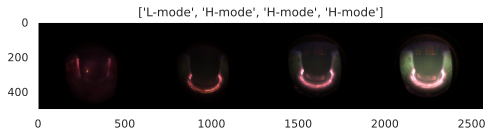

In [8]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    fig, ax = plt.subplots(figsize=(8,6))
    ax.imshow(inp)
    ax.grid(False)
    if title is not None:
        plt.title(title)


modes = ['L-mode', 'H-mode', 'ELM']


example_batch = next(iter(test_dataloader))
example_inputs, example_classes,  _ = example_batch #we don't need img paths

#Denormalize inputs. Dividing the mean by 255 is conditioned by, that normalization is made on pictures with (0.:1.) values. Look for normalized image in ImageDataset() 
denormalized_inputs = example_inputs * std[:, None, None] + mean[:, None, None]/255

# Make a grid from batch
wide_image = torchvision.utils.make_grid(denormalized_inputs[:4])
imshow(wide_image, title=[modes[x] for x in example_classes[:4]])

## Playing with TensorBoard

In [9]:
timestamp = input('add comment: ') + datetime.fromtimestamp(time.time()).strftime("-%d-%m-%Y, %H-%M-%S")#9 times!

# create grid of images
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f'runs/{timestamp}')

# write to tensorboard
writer.add_image(f'run {timestamp} four_compass images', wide_image)
writer.close()

add comment: Run with unfreezed layers. Binary classification 


## Import ResNet pretrained model


In [10]:
pretrained_model = torchvision.models.resnet18(weights='IMAGENET1K_V1', )
num_ftrs = pretrained_model.fc.in_features
# Here the size of each output sample is set to 3.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(modes))``.
pretrained_model.fc = torch.nn.Linear(num_ftrs, 3) #3 classes: L-mode, H-mode, ELM


### I will try to freeze all layers except 4-th and fc layer

In [11]:
# for name, para in pretrained_model.named_parameters():
#     if "layer4" in name or "fc" in name:
#         continue
#     else:
#         para.requires_grad = False

### Alternatively freeze all the weights excepts those of last fc layer

In [12]:
for param in pretrained_model.parameters():
    param.requires_grad = False
 
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_ftrs, 3) #3 classes: L-mode, H-mode, ELM

In [13]:
pretrained_model = pretrained_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(pretrained_model.parameters(), lr=0.001) #pouzit adam

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [14]:
#adding graph of the model to tensorboard
writer.add_graph(pretrained_model, example_inputs.float().to(device))
writer.close()

### Tracking model training with TensorBoard

In [15]:
def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1) 
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [torch.nn.functional.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, img_paths, labels, identificator):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along   
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    timestamp = datetime.fromtimestamp(time.time()).strftime("%d-%m-%Y, %H-%M-%S")
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(16,9))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        image = read_image(img_paths[idx]).numpy()
        plt.grid(False)
        plt.imshow(np.transpose(image, (1, 2, 0)))
        ax.set_title("Prediction: {0}, {1:.1f}%\n(Label: {2})".format(
            modes[preds[idx]],
            probs[idx] * 100.0,
            modes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    plt.savefig(f'/compass/Shared/Users/bogdanov/vyzkumny_ukol/preds_vs_actuals/preds_vs_actuals_{timestamp}_{identificator}.jpg')
    return fig



## Training
### Original training function was copied from [tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#finetuning-the-convnet) and modified in order to integrate tensorboard

In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
    
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0
                num_of_samples = 0
                running_batch = 0
                # Iterate over data.
                #TODO: eliminate the need in that dummy iterative for tensorboard part
                for inputs, labels, img_paths in tqdm(dataloaders[phase]):
                    inputs = inputs.to(device).float() # #TODO: is it smart to convert double to float here? 
                    labels = labels.to(device)
                    
                    running_batch += 1
                    
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs) #2D tensor with shape Batchsize*len(modes)
                        #TODO: inputs.type. 
                        _, preds = torch.max(outputs, 1) #preds = 1D array of indicies of maximum values in row. ([2,1,2,1,2]) - third feature is largest in first sample, second in second...
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0) #!!! Why is it multiplied by batchsize???
                    num_of_samples += inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data) #How many correct answers
                    
                    
                    #tensorboard part
                    
                    if running_batch % int(len(dataloaders[phase])/10)==int(len(dataloaders[phase])/10)-1: 
                        # ...log the running loss
                        
                        writer.add_scalar(f'{phase}ing loss',
                                        running_loss / num_of_samples,
                                        epoch * len(dataloaders[phase]) + running_batch)
                        
                        
                    
                    if running_batch % int(len(dataloaders[phase])/3)==int(len(dataloaders[phase])/3)-1:
                        # ...log a Matplotlib Figure showing the model's predictions on a
                        # random mini-batch
                        writer.add_figure('predictions vs. actuals',
                                        plot_classes_preds(model, inputs, img_paths, labels, identificator=phase),
                                        global_step=epoch * len(dataloaders[phase]) + running_batch)
                        writer.close()
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    writer.add_scalar(f'best_accuracy for epoch',
                                        epoch_acc,
                                        epoch)
                    writer.close()
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

## Train last .fc layer

In [17]:
%matplotlib ipympl
model = train_model(pretrained_model, criterion, optimizer,
                                 exp_lr_scheduler, num_epochs=3)

model_path = Path(f'/compass/Shared/Users/bogdanov/vyzkumny_ukol/runs/model_{timestamp}.pt')
torch.save(model.state_dict(), model_path)

Epoch 1/3
----------


  0%|          | 0/280 [00:00<?, ?it/s]

train Loss: 0.2814 Acc: 0.9101


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.1723 Acc: 0.9426

Epoch 2/3
----------


  0%|          | 0/280 [00:00<?, ?it/s]

train Loss: 0.1225 Acc: 0.9708


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.1074 Acc: 0.9682

Epoch 3/3
----------


  0%|          | 0/280 [00:00<?, ?it/s]

train Loss: 0.0856 Acc: 0.9802


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.1073 Acc: 0.9636

Training complete in 9m 13s
Best val Acc: 0.968238


<Axes: >

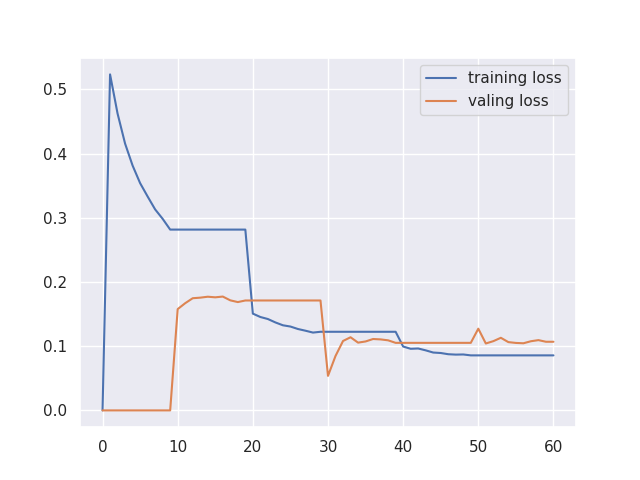

In [18]:
losses_df.plot()

### or import previously trained model

In [19]:
from pathlib import Path

model_path = Path('/compass/Shared/Users/bogdanov/vyzkumny_ukol/runs/model_26-11-2023, 18-08-11.pt')#f'/compass/Shared/Users/bogdanov/vyzkumny_ukol/runs/model_{timestamp}')

#model = pretrained_model.load_state_dict(torch.load(model_path))

## Testing

Model predicted that is a H-mode with 73.0% confidence


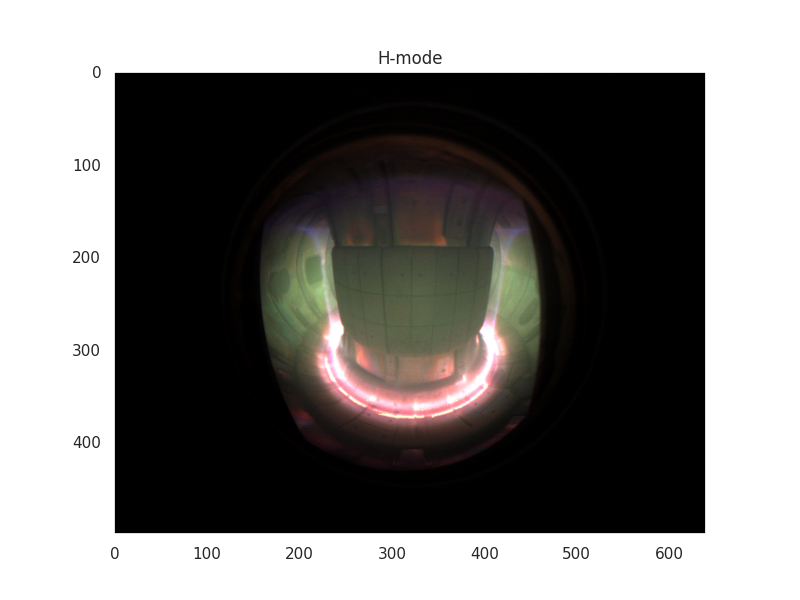

In [20]:
random_index = np.random.randint(0,batch_size-1)
predictions, confidences = images_to_probs(model,example_inputs.float().to(device))

pred, con = predictions[random_index], confidences[random_index]

imshow(denormalized_inputs[random_index], title=modes[example_classes[random_index]])
print(f"Model predicted that is a {modes[pred]} with {con*100:3.1f}% confidence") 

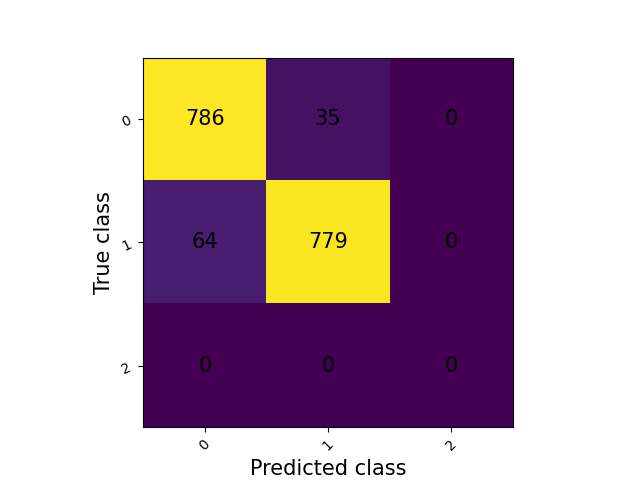

In [21]:
from torchmetrics.classification import MulticlassConfusionMatrix

def test_model(model, test_dataloader)
    y_df = torch.tensor([])
    y_hat_df = torch.tensor([])
    wrong_preds = pd.DataFrame(columns=['path', 'Prediction', 'label'])

    for batch_index, (img, y, paths) in enumerate(test_dataloader):
        y_hat, _ = images_to_probs(model,img.float().to(device))
        y_hat = torch.tensor(y_hat)
        y_df = torch.cat((y_df, y), dim=0)
        y_hat_df = torch.cat((y_hat_df, y_hat), dim=0)

        wrong_pred = pd.DataFrame([[paths[x], y_hat[x].item(), y[x].item()] for x in torch.where(y!=y_hat)[0]],
                                  columns=wrong_preds.columns)

        wrong_preds = pd.concat([wrong_preds, wrong_pred],axis=0, ignore_index=True)

        if batch_index>50:
            break

    metric = MulticlassConfusionMatrix(num_classes=3)
    metric.update(y_hat_df, y_df)
    fig_, ax_ = metric.plot()
    return fig_

confusion_matrix = test_model(model, test_dataloader)

## Unfreeze all layers and complete the training

In [22]:
for param in model.parameters():
    param.requires_grad = True

model = train_model(pretrained_model, criterion, optimizer,
                         exp_lr_scheduler, num_epochs=6)

Epoch 1/6
----------


  0%|          | 0/280 [00:00<?, ?it/s]

train Loss: 0.0774 Acc: 0.9775


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.2616 Acc: 0.9570

Epoch 2/6
----------


  0%|          | 0/280 [00:00<?, ?it/s]

train Loss: 0.0319 Acc: 0.9914


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.1789 Acc: 0.9739

Epoch 3/6
----------


  0%|          | 0/280 [00:00<?, ?it/s]

train Loss: 0.0221 Acc: 0.9949


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.1257 Acc: 0.9688

Epoch 4/6
----------


  0%|          | 0/280 [00:00<?, ?it/s]

train Loss: 0.0285 Acc: 0.9911


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.1608 Acc: 0.9775

Epoch 5/6
----------


  0%|          | 0/280 [00:00<?, ?it/s]

train Loss: 0.0180 Acc: 0.9942


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.1891 Acc: 0.9734

Epoch 6/6
----------


  0%|          | 0/280 [00:00<?, ?it/s]

train Loss: 0.0104 Acc: 0.9969


  0%|          | 0/61 [00:00<?, ?it/s]

val Loss: 0.2322 Acc: 0.9672

Training complete in 25m 26s
Best val Acc: 0.977459


<Axes: >

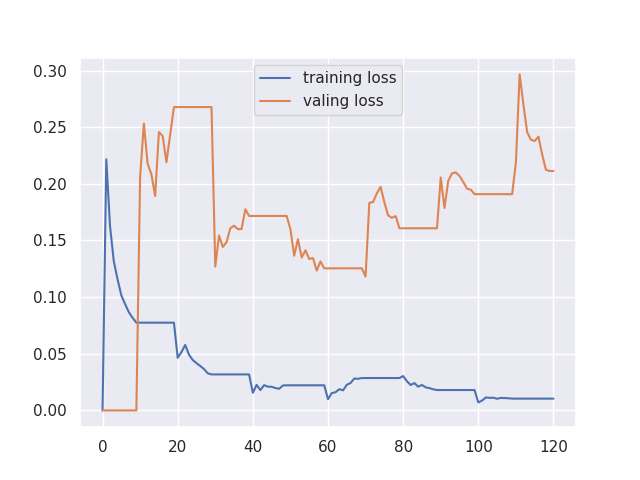

In [27]:
losses_df = model[1]

losses_df.plot()

In [28]:
torch.save(model[0].state_dict(), model_path)

## Testing fully trained model

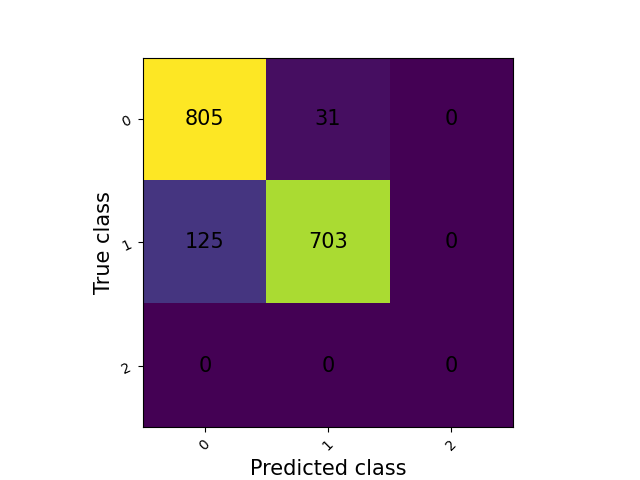

In [30]:
from torchmetrics.classification import MulticlassConfusionMatrix

y_df = torch.tensor([])
y_hat_df = torch.tensor([])
wrong_preds = pd.DataFrame(columns=['path', 'Prediction', 'label'])

for batch_index, (img, y, paths) in enumerate(test_dataloader):
    y_hat, _ = images_to_probs(model,img.float().to(device))
    y_hat = torch.tensor(y_hat)
    y_df = torch.cat((y_df, y), dim=0)
    y_hat_df = torch.cat((y_hat_df, y_hat), dim=0)
    
    wrong_pred = pd.DataFrame([[paths[x], y_hat[x].item(), y[x].item()] for x in torch.where(y!=y_hat)[0]],
                              columns=wrong_preds.columns)
    
    wrong_preds = pd.concat([wrong_preds, wrong_pred],axis=0, ignore_index=True)
    
    if batch_index>50:
        break

metric = MulticlassConfusionMatrix(num_classes=3)
metric.update(y_hat_df, y_df)
fig_, ax_ = metric.plot()

## Tensorboard

In [32]:
def embed_imgs(model, data_loader, num_of_batches):
    # Encode all images in the data_laoder using model, and return both images and encodings
    img_list, embed_list, labels_list, paths_list = [], [], [], []
    model.eval()
    for imgs, labels, img_paths in tqdm(data_loader, desc="Encoding images", leave=False, total=num_of_batches):
        with torch.no_grad():
            z = model(imgs.to(device).float())
        img_list.append(imgs)
        embed_list.append(z)
        labels_list.append(labels)
        paths_list.append(img_paths)
        if len(embed_list)>num_of_batches:
            break
    return torch.cat(img_list, dim=0), torch.cat(embed_list, dim=0), torch.cat(labels_list, dim=0),  [j for sub in paths_list for j in sub]

num_of_batches = 3
train_img_embeds = embed_imgs(model, train_dataloader, num_of_batches=num_of_batches)
test_img_embeds = embed_imgs(model, test_dataloader, num_of_batches=num_of_batches)

Encoding images:   0%|          | 0/3 [00:00<?, ?it/s]

Encoding images:   0%|          | 0/3 [00:00<?, ?it/s]

In [33]:
imgs, features, labels, img_paths = test_img_embeds

Denormolize imgs

In [43]:
NUM_IMGS = 100

# get the class labels for each image
class_labels = [modes[lab] for lab in labels[:NUM_IMGS]]

writer.add_embedding(
    features[:NUM_IMGS],  # Encodings per image
    metadata=class_labels,  # Adding the labels per image to the plot
    label_img=(test_img_embeds[0][:NUM_IMGS] * std[:, None, None] + mean[:, None, None]/255),
)  # Adding the original images to the plot

writer.close()

In [37]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.